This Jupyter Notebook describes the first of two experiments presented across Figure 3 and Extended Data Figure 7.

The data shown in 3A, 3B, E7A, and E7B compares DM-Seq to BS-Seq.

In [1]:
#packages
library(tidyr)
library(dplyr)
library(ggplot2)
library(R.utils)
library(stringr)
library(ggpubr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.1 (2020-08-26 16:20:06 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.24.0 (2020-08-26 16:11:58 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.11.0 (2021-09-26 08:30:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:tidyr’:

    extract

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked fr

Figure 3B can be visualized in IGV.

In [2]:
#read files and create dataframe
file <- read.csv(file = 'mGpC_BS.txt', header=FALSE, sep='\t') #coverage2cytosine report deposited to GEO
data_BS = tbl_df(file)

file <- read.csv(file = 'mGpC_DM.txt', header=FALSE, sep='\t') #coverage2cytosine report deposited to GEO
data_DM = tbl_df(file)

Warning message:
“`tbl_df()` was deprecated in dplyr 1.0.0.
Please use `tibble::as_tibble()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”

This section of code uses the 3' base of the opposite strand to determine the 5' base of the target strand.

First, here is the BS-Seq data.

In [3]:
#make data frames with sense and antisense strands, changing the antisense "sense" variable to match the sense strand so the strands are coupled.
data_sense <- data_BS %>% filter (V3=="+") %>% mutate (sense = V2)
data_antisense <- data_BS %>% filter (V3=="-") %>% mutate (sense = V2 - 1)

#bind back and create a string which tells you sequence context in both directions.
data2 <- bind_rows(data_sense,data_antisense) %>% group_by(sense) %>% mutate(both_ends = toString(V7))

#filter back individual strands after generating new row
data_sense <- data2 %>% filter (V3=="+")
data_antisense <- data2 %>% filter (V3=="-")

#make 5' row for just the negative strand.
data_antisense <- data_antisense %>% mutate(opp_minus_one_pos = str_sub(both_ends,3,3))
data_antisense <- data_antisense %>% mutate(minus_one_pos = case_when(opp_minus_one_pos == "C" ~ "G", opp_minus_one_pos == "G" ~ "C", opp_minus_one_pos == "A" ~ "T", opp_minus_one_pos == "T" ~ "A"))

#make 5' row for just the positive strand.
data_sense <- data_sense %>% mutate(opp_minus_one_pos = str_sub(both_ends,-1,-1))
data_sense <- data_sense %>% mutate(minus_one_pos = case_when(opp_minus_one_pos == "C" ~ "G", opp_minus_one_pos == "G" ~ "C", opp_minus_one_pos == "A" ~ "T", opp_minus_one_pos == "T" ~ "A"))

#bind back for final dataset
data_BS_final <- bind_rows(data_sense,data_antisense) %>% group_by(sense)
data_BS_final <- data_BS_final %>% mutate(percent_c = 100*V4/(V4+V5))
data_BS_final <- data_BS_final %>% mutate(percent_t = 100*V5/(V4+V5))

#remove nas
data_BS_final <- na.omit(data_BS_final)

Next, this is the DM-Seq data.

In [4]:
#make data frames with sense and antisense strands, changing the antisense "sense" variable to match the sense strand so the strands are coupled.
data_sense <- data_DM %>% filter (V3=="+") %>% mutate (sense = V2)
data_antisense <- data_DM %>% filter (V3=="-") %>% mutate (sense = V2 - 1)

#bind back and create a string which tells you sequence context in both directions.
data2 <- bind_rows(data_sense,data_antisense) %>% group_by(sense) %>% mutate(both_ends = toString(V7))

#filter back individual strands after generating new row
data_sense <- data2 %>% filter (V3=="+")
data_antisense <- data2 %>% filter (V3=="-")

#make 5' row for just the negative strand.
data_antisense <- data_antisense %>% mutate(opp_minus_one_pos = str_sub(both_ends,3,3))
data_antisense <- data_antisense %>% mutate(minus_one_pos = case_when(opp_minus_one_pos == "C" ~ "G", opp_minus_one_pos == "G" ~ "C", opp_minus_one_pos == "A" ~ "T", opp_minus_one_pos == "T" ~ "A"))

#make 5' row for just the positive strand.
data_sense <- data_sense %>% mutate(opp_minus_one_pos = str_sub(both_ends,-1,-1))
data_sense <- data_sense %>% mutate(minus_one_pos = case_when(opp_minus_one_pos == "C" ~ "G", opp_minus_one_pos == "G" ~ "C", opp_minus_one_pos == "A" ~ "T", opp_minus_one_pos == "T" ~ "A"))

#bind back for final dataset
data_DM_final <- bind_rows(data_sense,data_antisense) %>% group_by(sense)
data_DM_final <- data_DM_final %>% mutate(percent_c = 100*V4/(V4+V5))
data_DM_final <- data_DM_final %>% mutate(percent_t = 100*V5/(V4+V5))

#remove nas
data_DM_final <- na.omit(data_DM_final)

# Extended Data Figure 7A

In [5]:
#join BS and DM data to one
data_BS_DM <- inner_join(data_BS_final,data_DM_final, by = c("V2"))

#rename variables to label percent modification for each method
data_BS_DM <- data_BS_DM %>% mutate (BS = percent_c.x)
data_BS_DM <- data_BS_DM %>% mutate (DM = 100 - percent_c.y)

#filter only CCGs to validate heterogeneity
data_BS_DM <- data_BS_DM %>% filter (minus_one_pos.x == "C") 

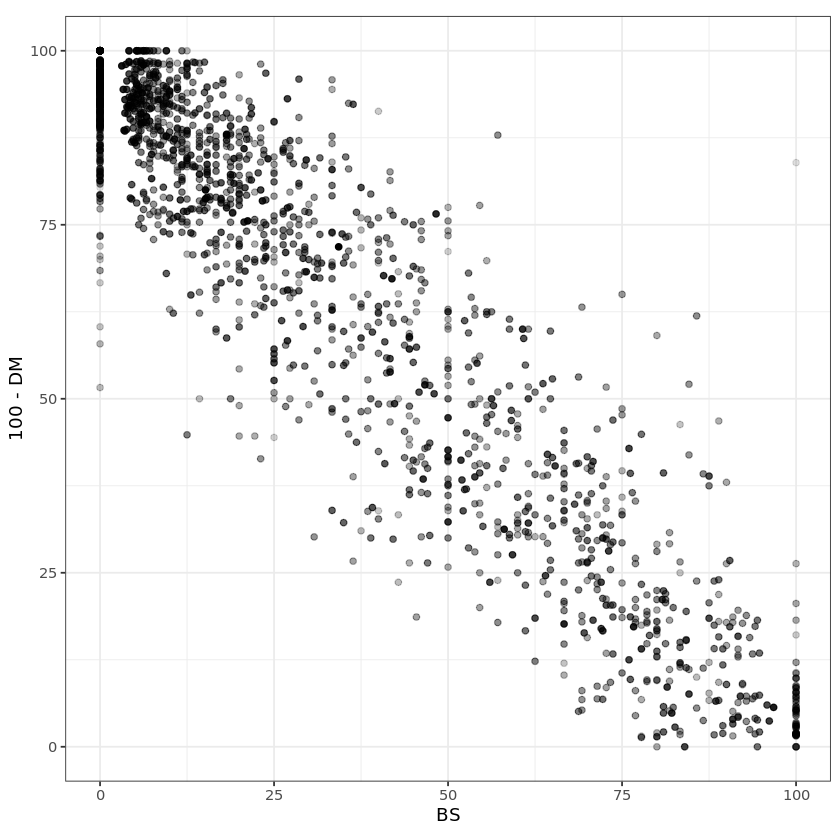

In [6]:
#plot correlation at CCGs, weighting darkness by BS-Seq coverage
p <- ggplot(data_BS_DM, aes(x=BS, y=100-DM, alpha = V4.x+V5.x)) + geom_point() + xlim(0,100) + ylim(0,100)  + theme_bw() + theme(aspect.ratio = 1, legend.position="none") 

p

In [7]:
#calculate pearson
cor(data_BS_DM$BS,100-data_BS_DM$DM)

[1] -0.9380184

# Extended Data Figure 7B

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”Warning message:
“`show_guide` has been deprecated. Please use `show.legend` instead.”

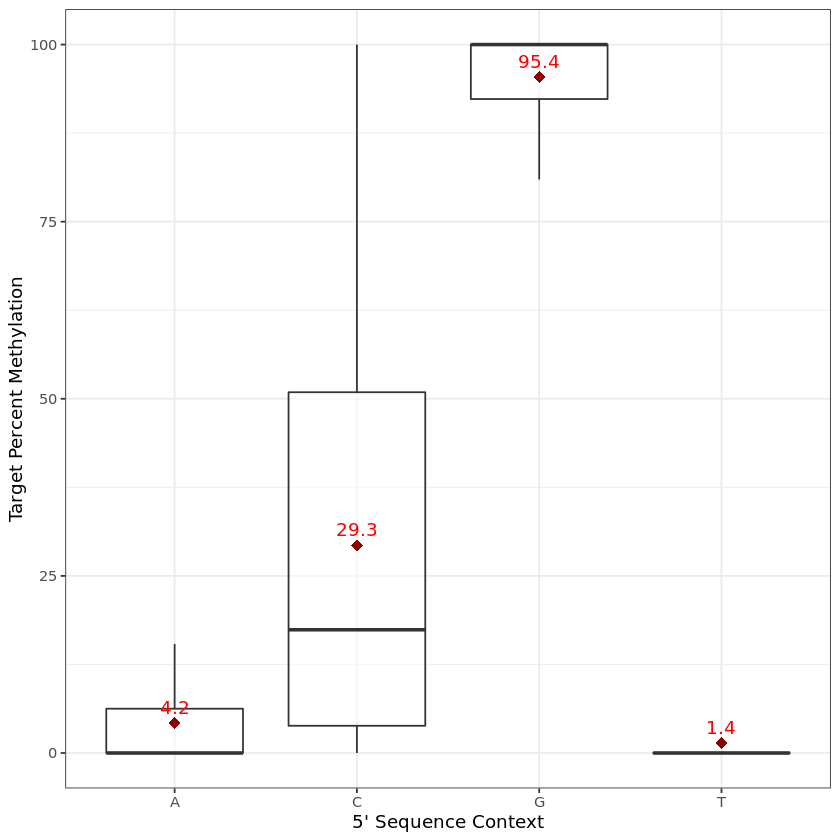

In [8]:
#make a boxplot for BS-Seq
p <- ggplot(data_BS_final, aes(x=minus_one_pos, y=100-percent_t)) + geom_boxplot(alpha=0.5, outlier.colour = NA) + stat_summary(fun=mean, colour="darkred", geom="point", 
                                                                                                                         shape=18, size=3, show.legend=FALSE) + stat_summary(fun.y=mean, colour="red", geom="text", show_guide = FALSE, 
                                                                                                                                                                             vjust=-0.7, aes( label=round(..y.., digits=1))) + theme_bw()
p + labs(x="5' Sequence Context", y = "Target Percent Methylation") + ylim(0, 100)

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”Warning message:
“`show_guide` has been deprecated. Please use `show.legend` instead.”

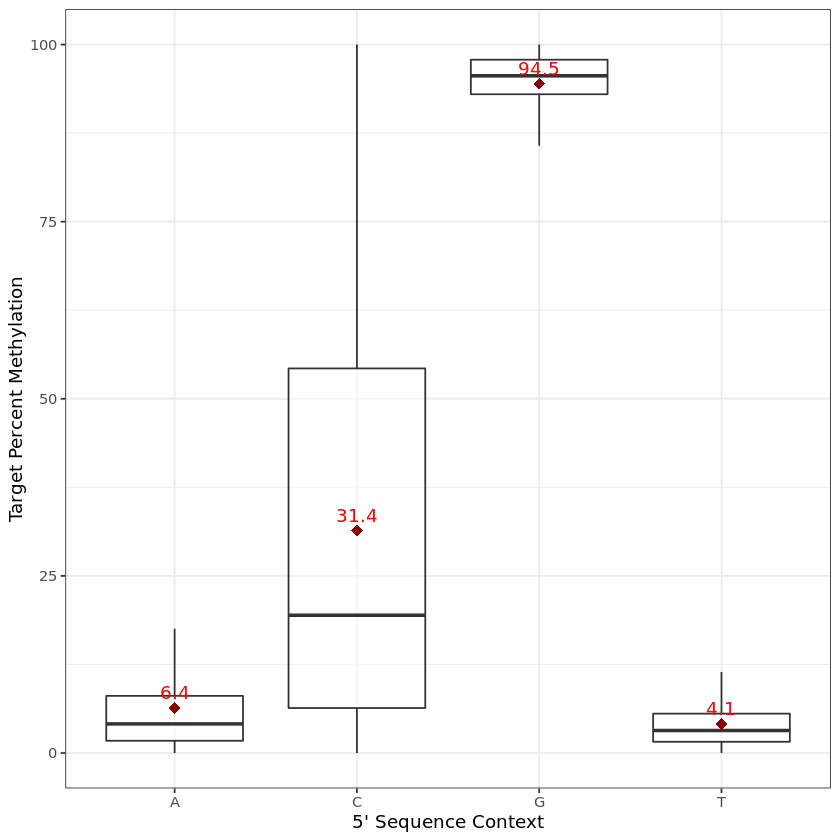

In [9]:
#make a boxplot for DM-Seq
p <- ggplot(data_DM_final, aes(x=minus_one_pos, y=percent_t)) + geom_boxplot(alpha=0.5, outlier.colour = NA) + stat_summary(fun=mean, colour="darkred", geom="point", 
                                                                                                                         shape=18, size=3, show.legend=FALSE) + stat_summary(fun.y=mean, colour="red", geom="text", show_guide = FALSE, 
                                                                                                                                                                             vjust=-0.7, aes( label=round(..y.., digits=1))) + theme_bw()
p + labs(x="5' Sequence Context", y = "Target Percent Methylation") + ylim(0, 100)